# VQ-VAE Implementation in PyTorch

In [21]:
#  Vector Quantized VAE (VQ-VAE)
# - Dataset: MNIST
# - Train/Val split: 70/30 of the 60k "train" file
# - Test: fixed 10k "t10k" file

In [22]:
# Imports
import time, math, json, struct, gzip
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from PIL import Image

In [23]:
# Config
class QCfg:
    # Paths
    ROOT      = Path(".")
    DATA_DIR  = ROOT / "mnist"
    TRAIN_DIR = DATA_DIR / "train"
    TEST_DIR  = DATA_DIR / "test"

    # Splits
    TRAIN_FRACTION = 0.70

    # Training
    BATCH_SIZE   = 256
    EPOCHS       = 50
    LR           = 1e-3
    WEIGHT_DECAY = 1e-4
    NUM_WORKERS  = 0
    AMP          = False

    # Early stopping
    PATIENCE  = 3
    MIN_DELTA = 1e-5

    # VQ-VAE specific
    CODEBOOK_SIZE = 512         # K (number of code vectors)
    EMBED_DIM     = 96          # D (embedding/channel size in latent)
    COMMIT_BETA   = 0.15        # β for commitment loss
    EMA_DECAY     = 0.95        # EMA decay for codebook updates
    EMA_EPS       = 1e-5

    # Outputs
    OUT_DIR  = ROOT / "output"
    EXP_NAME = time.strftime("vqvae_%Y%m%d_%H%M%S")

    # Repro
    SEED = 42

qcfg = QCfg()

# run folder
vq_exp_dir = qcfg.OUT_DIR / qcfg.EXP_NAME
vq_exp_dir.mkdir(parents=True, exist_ok=True)

# Device & seeds
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    qcfg.AMP = True

torch.manual_seed(qcfg.SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(qcfg.SEED)

print("Device     :", device)
print("Train dir  :", qcfg.TRAIN_DIR.resolve())
print("Test dir   :", qcfg.TEST_DIR.resolve())
print("Run folder :", vq_exp_dir.resolve())
print(f"VQ-VAE: K={qcfg.CODEBOOK_SIZE}, D={qcfg.EMBED_DIM}, beta={qcfg.COMMIT_BETA}, ema_decay={qcfg.EMA_DECAY}")

Device     : cpu
Train dir  : /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/mnist/train
Test dir   : /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/mnist/test
Run folder : /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/output/vqvae_20250925_040159
VQ-VAE: K=512, D=96, beta=0.15, ema_decay=0.95


In [24]:
# Transforms
from torchvision import transforms

to_tensor_norm = transforms.Compose([
    transforms.ToTensor(),                 # [0,1]
    transforms.Normalize((0.5,), (0.5,))   # -> [-1,1]
])
inv_normalize = transforms.Normalize(mean=[-1*0.5/0.5], std=[1/0.5])

In [25]:
# Dataset
def _open_idx(path: Path):
    # Supports .idx3-ubyte and .idx3-ubyte.gz
    return gzip.open(path, "rb") if path.suffix == ".gz" else open(path, "rb")

def parse_idx_images(path: Path) -> np.ndarray:
    """Parse IDX image file (magic 2051) → numpy uint8 array (N, 28, 28)."""
    with _open_idx(path) as f:
        header = f.read(16)
        if len(header) != 16:
            raise RuntimeError(f"Malformed IDX header in {path}")
        magic, num, rows, cols = struct.unpack(">IIII", header)
        if magic != 2051:
            raise RuntimeError(f"Invalid IDX magic {magic} in {path} (expected 2051)")
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data.reshape(num, rows, cols)

class MNISTIdxDataset(Dataset):
    """Wraps (N,28,28) uint8 images; target == input (unsupervised)."""
    def __init__(self, images: np.ndarray, transform=None):
        self.images = images
        self.transform = transform
    def __len__(self): return len(self.images)
    def __getitem__(self, idx):
        img = Image.fromarray(self.images[idx], mode="L")
        x = self.transform(img) if self.transform else transforms.ToTensor()(img)
        return x, x

In [26]:
# paths
def find_idx_in_dir(dir_path: Path, candidates):
    # check exact names first, then recurse
    for fn in candidates:
        p = dir_path / fn
        if p.exists(): return p
    for p in dir_path.rglob("*"):
        if p.is_file() and p.name in candidates:
            return p
    return None

train_candidates = [
    "train-images.idx3-ubyte",
    "train-images-idx3-ubyte.gz",
]
test_candidates = [
    "t10k-images.idx3-ubyte",
    "t10k-images-idx3-ubyte.gz",
]

train_dir = qcfg.TRAIN_DIR.resolve()
test_dir  = qcfg.TEST_DIR.resolve()

train_idx_path = find_idx_in_dir(train_dir, train_candidates)
test_idx_path  = find_idx_in_dir(test_dir,  test_candidates)

print("Train dir :", train_dir)
print("Test dir  :", test_dir)
print("Train IDX :", train_idx_path)
print("Test  IDX :", test_idx_path)
if train_idx_path is None:
    raise RuntimeError("Could not find a train IDX in mnist/train. "
                       f"Expected one of: {', '.join(train_candidates)}")

Train dir : /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/mnist/train
Test dir  : /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/mnist/test
Train IDX : /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/mnist/train/train-images.idx3-ubyte
Test  IDX : /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/mnist/test/t10k-images.idx3-ubyte


In [27]:
# Build datasets, split, and dataloaders
g = torch.Generator().manual_seed(qcfg.SEED)

# Load IDX arrays
train_images = parse_idx_images(train_idx_path)
print("Loaded train images:", train_images.shape)

test_images = None
if test_idx_path is not None:
    test_images = parse_idx_images(test_idx_path)
    print("Loaded test images :", test_images.shape)
else:
    print("No separate test IDX found — will split single file 70/15/15.")

# Datasets & splits
if test_images is not None:
    full_ds = MNISTIdxDataset(train_images, transform=to_tensor_norm)
    test_ds = MNISTIdxDataset(test_images,  transform=to_tensor_norm)

    n_full  = len(full_ds)                      # 60_000
    n_train = int(qcfg.TRAIN_FRACTION * n_full) # 42_000 (70%)
    n_val   = n_full - n_train                  # 18_000 (30%)
    train_ds, val_ds = random_split(full_ds, [n_train, n_val], generator=g)
else:
    full_ds = MNISTIdxDataset(train_images, transform=to_tensor_norm)
    n_full  = len(full_ds)
    n_train = int(qcfg.TRAIN_FRACTION * n_full) # 70%
    n_rest  = n_full - n_train                  # 30%
    n_val   = n_rest // 2                       # 15%
    n_test  = n_rest - n_val                    # 15%
    train_ds, val_ds, test_ds = random_split(full_ds, [n_train, n_val, n_test], generator=g)

print(f"Final splits → Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")

# DataLoaders
pin = (device.type == "cuda")
train_loader = DataLoader(train_ds, batch_size=qcfg.BATCH_SIZE, shuffle=True,
                          num_workers=qcfg.NUM_WORKERS, pin_memory=pin)
val_loader   = DataLoader(val_ds,   batch_size=qcfg.BATCH_SIZE, shuffle=False,
                          num_workers=qcfg.NUM_WORKERS, pin_memory=pin)
test_loader  = DataLoader(test_ds,  batch_size=qcfg.BATCH_SIZE, shuffle=False,
                          num_workers=qcfg.NUM_WORKERS, pin_memory=pin)

print("pin_memory:", pin, "| batch_size:", qcfg.BATCH_SIZE, "| workers:", qcfg.NUM_WORKERS)

Loaded train images: (60000, 28, 28)
Loaded test images : (10000, 28, 28)
Final splits → Train: 42000 | Val: 18000 | Test: 10000
pin_memory: False | batch_size: 256 | workers: 0


/var/folders/cf/v0g4pk7s2sng485qdzddqbhc0000gn/T/ipykernel_20642/2265518861.py:25: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(self.images[idx], mode="L")


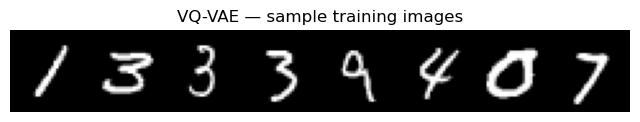

In [28]:
# Quick sanity Check
xb, _ = next(iter(train_loader))
xb_vis = inv_normalize(xb[:8].cpu()).clamp(0,1)
grid = make_grid(xb_vis, nrow=8, padding=2)
plt.figure(figsize=(8,2))
plt.axis('off'); plt.title("VQ-VAE — sample training images")
plt.imshow(np.transpose(grid.numpy(), (1,2,0)), cmap='gray')
plt.show()

In [29]:
# VQ-VAE model
# - Encoder downsamples 28→14→7 and outputs D=qcfg.EMBED_DIM channels.
# - VectorQuantizer **EMA** codebook (K=qcfg.CODEBOOK_SIZE, D channels).
# - Straight-through estimator for the backward pass.
# - Decoder upsamples 7→14→28 and outputs tanh in [-1, 1].
# - Forward returns: reconstruction, commitment loss, perplexity, and code indices.

import math

class ConvBlock(nn.Module):
    def __init__(self, cin, cout, gn_groups=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(cin, cout, 3, padding=1),
            nn.GroupNorm(min(gn_groups, cout), cout),
            nn.SiLU(),
            nn.Conv2d(cout, cout, 3, padding=1),
            nn.GroupNorm(min(gn_groups, cout), cout),
            nn.SiLU(),
        )
    def forward(self, x): return self.net(x)

class Down(nn.Module):
    """ConvBlock then stride-2 downsample (28→14 or 14→7)."""
    def __init__(self, cin, cout):
        super().__init__()
        self.block = ConvBlock(cin, cout)
        self.down  = nn.Conv2d(cout, cout, kernel_size=2, stride=2)
    def forward(self, x):
        x = self.block(x)
        x = self.down(x)
        return x

class Up(nn.Module):
    """Stride-2 upsample then ConvBlock (7→14 or 14→28)."""
    def __init__(self, cin, cout):
        super().__init__()
        self.up   = nn.ConvTranspose2d(cin, cout, kernel_size=2, stride=2)
        self.block= ConvBlock(cout, cout)
    def forward(self, x):
        x = self.up(x)
        x = self.block(x)
        return x

In [30]:
# VectorQuantizer with EMA codebook updates
class VectorQuantizerEMA(nn.Module):
    """
    VQ layer with EMA codebook updates (no explicit codebook loss).
    - K: number of code vectors (codebook size)
    - D: embedding dimension (must match encoder channels)
    - decay: EMA decay for cluster sizes and embedding averages
    - eps: small constant for numerical stability
    - beta_commit: scales the commitment loss ||sg[z_e] - z_q||^2
    Returns:
      z_q (quantized), commit_loss (scalar), perplexity (scalar), indices (B,H,W)
    """
    def __init__(self, K, D, decay=0.99, eps=1e-5, beta_commit=0.25):
        super().__init__()
        self.K = K
        self.D = D
        self.decay = decay
        self.eps = eps
        self.beta = beta_commit

        embed = torch.randn(K, D) / D**0.5
        self.register_buffer("embedding", embed)           # (K, D)
        self.register_buffer("cluster_size", torch.zeros(K))
        self.register_buffer("embed_avg", embed.clone())   # EMA of embeddings

    def forward(self, z_e):
        """
        z_e: encoder outputs, shape (B, D, H, W)
        """
        B, D, H, W = z_e.shape
        assert D == self.D, f"Embed dim mismatch: got {D}, expected {self.D}"

        # Flatten to (N, D)
        z = z_e.permute(0, 2, 3, 1).contiguous()      # (B,H,W,D)
        flat = z.view(-1, D)                          # (N,D), N=B*H*W

        # Squared L2 distances to codebook: ||x - e||^2 = x^2 + e^2 - 2 x·e
        # shapes: flat (N,D), embedding (K,D)
        dist = (
            flat.pow(2).sum(1, keepdim=True)          # (N,1)
            + self.embedding.pow(2).sum(1)            # (K,)
            - 2 * flat @ self.embedding.t()           # (N,K)
        )

        # Encoding indices and one-hot
        indices = torch.argmin(dist, dim=1)           # (N,)
        encodings = F.one_hot(indices, self.K).type(flat.dtype)  # (N,K)

        # Quantize and reshape back
        quant = encodings @ self.embedding            # (N,D)
        quant = quant.view(B, H, W, D).permute(0, 3, 1, 2).contiguous()  # (B,D,H,W)

        # EMA updates (training only)
        if self.training:
            # EMA cluster size
            new_cluster_size = encodings.sum(0)       # (K,)
            self.cluster_size.mul_(self.decay).add_( (1 - self.decay) * new_cluster_size )

            # EMA embedding average
            embed_sum = encodings.t() @ flat          # (K,D)
            self.embed_avg.mul_(self.decay).add_( (1 - self.decay) * embed_sum )

            # Normalize to get updated embeddings
            n = self.cluster_size.sum()
            # Laplace smoothing of cluster sizes
            cluster_size = (self.cluster_size + self.eps) / (n + self.K * self.eps) * n
            embed_normalized = self.embed_avg / cluster_size.unsqueeze(1)
            self.embedding.copy_(embed_normalized)

        # Commitment loss (EMA variant doesn’t use separate codebook loss)
        commit_loss = self.beta * F.mse_loss(quant.detach(), z_e)

        # Straight-through estimator
        z_q = z_e + (quant - z_e).detach()

        # Perplexity over usage of codebook entries
        avg_probs = encodings.float().mean(0) + 1e-10
        perplexity = torch.exp(-(avg_probs * avg_probs.log()).sum())

        # Index map (B,H,W)
        idx_map = indices.view(B, H, W)

        return z_q, commit_loss, perplexity, idx_map

In [31]:
# VQ-VAE encoder / decoder / model
class Encoder(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.GroupNorm(8, 32), nn.SiLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.GroupNorm(8, 32), nn.SiLU(),

            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # 28 → 14
            nn.GroupNorm(8, 64), nn.SiLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.GroupNorm(8, 64), nn.SiLU(),

            nn.Conv2d(64, 128, 4, stride=2, padding=1), # 14 → 7
            nn.GroupNorm(16, 128), nn.SiLU(),
            nn.Conv2d(128, embed_dim, 1),               # project to D
        )
    def forward(self, x): return self.net(x)           # (B,D,7,7)

class Decoder(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(embed_dim, 128, 3, padding=1),
            nn.GroupNorm(16, 128), nn.SiLU(),

            nn.ConvTranspose2d(128, 64, 2, stride=2),  # 7 → 14
            nn.GroupNorm(8, 64), nn.SiLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.GroupNorm(8, 64), nn.SiLU(),

            nn.ConvTranspose2d(64, 32, 2, stride=2),   # 14 → 28
            nn.GroupNorm(8, 32), nn.SiLU(),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.SiLU(),
            nn.Conv2d(16, 1, 1),
            nn.Tanh(),                                  # [-1, 1]
        )
    def forward(self, z_q): return self.net(z_q)

class VQVAE(nn.Module):
    def __init__(self, K, D, beta_commit=0.25, ema_decay=0.99, ema_eps=1e-5):
        super().__init__()
        self.encoder = Encoder(D)
        self.quant   = VectorQuantizerEMA(K, D, decay=ema_decay, eps=ema_eps, beta_commit=beta_commit)
        self.decoder = Decoder(D)

    def forward(self, x):
        z_e = self.encoder(x)                                    # (B,D,7,7)
        z_q, commit_loss, perplexity, idx = self.quant(z_e)      # quantize
        xhat = self.decoder(z_q)                                  # reconstruct
        info = {"commit_loss": commit_loss, "perplexity": perplexity, "indices": idx}
        return xhat, info

In [32]:
# Instantiate and quick shape sanity check
vqvae = VQVAE(
    K=qcfg.CODEBOOK_SIZE,
    D=qcfg.EMBED_DIM,
    beta_commit=qcfg.COMMIT_BETA,
    ema_decay=qcfg.EMA_DECAY,
    ema_eps=qcfg.EMA_EPS,
).to(device)

print("VQ-VAE params (M):", sum(p.numel() for p in vqvae.parameters())/1e6)

vqvae.eval()
xb, _ = next(iter(train_loader))
xb = xb.to(device)[:8]
with torch.no_grad():
    xhat, info = vqvae(xb)
print("Input :", tuple(xb.shape))
print("Recon :", tuple(xhat.shape))
print("Commit loss (scalar):", float(info["commit_loss"]))
print("Perplexity (scalar) :", float(info["perplexity"]))
assert xhat.shape == xb.shape, "Decoder must reconstruct to (N,1,28,28)"

VQ-VAE params (M): 0.417473
Input : (8, 1, 28, 28)
Recon : (8, 1, 28, 28)
Commit loss (scalar): 0.014625358395278454
Perplexity (scalar) : 60.89039993286133


/var/folders/cf/v0g4pk7s2sng485qdzddqbhc0000gn/T/ipykernel_20642/2265518861.py:25: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(self.images[idx], mode="L")


In [33]:
# Training
# - Loss = reconstruction + commitment (EMA variant; no separate codebook loss)
# - Early stopping on **val total loss**
# - Saves:
#     - `best_model.pt`  (weights only)
#     - `best_val.ckpt`  (full checkpoint with optimizer state)
#     - `last.ckpt`      (final state)
#     - `history.json`   (training curves)

# Optimizer / scheduler / scaler
optimizer = torch.optim.AdamW(vqvae.parameters(), lr=qcfg.LR, weight_decay=qcfg.WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=max(5, qcfg.EPOCHS), T_mult=1
)
scaler = torch.cuda.amp.GradScaler(enabled=qcfg.AMP)

best_path_weights = vq_exp_dir / "best_model.pt"
best_path_ckpt    = vq_exp_dir / "best_val.ckpt"
last_path_ckpt    = vq_exp_dir / "last.ckpt"

def save_ckpt(path, model, optimizer, epoch, metrics: dict):
    torch.save({
        "epoch": epoch,
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "metrics": metrics,
        "cfg": vars(qcfg),
    }, path)

def recon_loss(xhat, x):
    # same hybrid as AE/VAE
    l1 = F.l1_loss(xhat, x)
    l2 = F.mse_loss(xhat, x)
    return 0.5*l1 + 0.5*l2, l1.item(), l2.item()

/var/folders/cf/v0g4pk7s2sng485qdzddqbhc0000gn/T/ipykernel_20642/215507809.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=qcfg.AMP)


In [34]:
# Train
import numpy as np

best_val = float("inf")
no_improve = 0
history = {
    "train_total": [], "train_recon": [], "train_commit": [], "train_perplex": [],
    "val_total":   [], "val_recon":   [], "val_commit":   [], "val_perplex":   []
}

for epoch in range(1, qcfg.EPOCHS + 1):
    # ---- Train ----
    vqvae.train()
    t_rec_vals, t_com_vals, t_tot_vals, t_ppl_vals = [], [], [], []
    for xb, _ in train_loader:
        xb = xb.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=qcfg.AMP):
            xhat, info = vqvae(xb)
            rec, _, _ = recon_loss(xhat, xb)
            commit = info["commit_loss"]
            loss = rec + commit
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(vqvae.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        t_rec_vals.append(rec.item())
        t_com_vals.append(float(commit))
        t_tot_vals.append(loss.item())
        t_ppl_vals.append(float(info["perplexity"]))
    scheduler.step(epoch)

    # ---- Validate ----
    vqvae.eval()
    v_rec_vals, v_com_vals, v_tot_vals, v_ppl_vals = [], [], [], []
    with torch.no_grad():
        for xb, _ in val_loader:
            xb = xb.to(device)
            xhat, info = vqvae(xb)
            rec, _, _ = recon_loss(xhat, xb)
            commit = info["commit_loss"]
            total = rec + commit
            v_rec_vals.append(rec.item())
            v_com_vals.append(float(commit))
            v_tot_vals.append(total.item())
            v_ppl_vals.append(float(info["perplexity"]))

    train_recon = float(np.mean(t_rec_vals)) if t_rec_vals else float("inf")
    train_commit= float(np.mean(t_com_vals)) if t_com_vals else float("inf")
    train_total = float(np.mean(t_tot_vals)) if t_tot_vals else float("inf")
    train_ppl   = float(np.mean(t_ppl_vals)) if t_ppl_vals else float("nan")

    val_recon   = float(np.mean(v_rec_vals)) if v_rec_vals else float("inf")
    val_commit  = float(np.mean(v_com_vals)) if v_com_vals else float("inf")
    val_total   = float(np.mean(v_tot_vals)) if v_tot_vals else float("inf")
    val_ppl     = float(np.mean(v_ppl_vals)) if v_ppl_vals else float("nan")

    history["train_total"].append(train_total)
    history["train_recon"].append(train_recon)
    history["train_commit"].append(train_commit)
    history["train_perplex"].append(train_ppl)
    history["val_total"].append(val_total)
    history["val_recon"].append(val_recon)
    history["val_commit"].append(val_commit)
    history["val_perplex"].append(val_ppl)

    print(f"Epoch {epoch:03d} | "
          f"train total {train_total:.5f} (rec {train_recon:.5f}, com {train_commit:.5f}, ppl {train_ppl:.1f}) | "
          f"val total {val_total:.5f} (rec {val_recon:.5f}, com {val_commit:.5f}, ppl {val_ppl:.1f})")

    # ---- Early stopping & best checkpoint ----
    if best_val - val_total > qcfg.MIN_DELTA:
        best_val = val_total
        no_improve = 0
        save_ckpt(best_path_ckpt, vqvae, optimizer, epoch,
                  {"val_total": val_total, "val_recon": val_recon, "val_commit": val_commit, "val_perplex": val_ppl})
        torch.save(vqvae.state_dict(), best_path_weights)
    else:
        no_improve += 1
        if no_improve >= qcfg.PATIENCE:
            print("Early stopping.")
            break

# Save last & history
save_ckpt(last_path_ckpt, vqvae, optimizer, epoch, {"val_total": val_total})
with open(vq_exp_dir / "history.json", "w") as f:
    json.dump(history, f, indent=2)

# Load best weights for downstream eval
vqvae.load_state_dict(torch.load(best_path_weights, map_location=device))
vqvae.eval()
print("Loaded best weights from:", best_path_weights.resolve())

/var/folders/cf/v0g4pk7s2sng485qdzddqbhc0000gn/T/ipykernel_20642/2265518861.py:25: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(self.images[idx], mode="L")
/var/folders/cf/v0g4pk7s2sng485qdzddqbhc0000gn/T/ipykernel_20642/1859298349.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=qcfg.AMP):


Epoch 001 | train total 0.10467 (rec 0.09377, com 0.01090, ppl 17.7) | val total 0.04714 (rec 0.03805, com 0.00908, ppl 23.4)
Epoch 002 | train total 0.03663 (rec 0.03007, com 0.00656, ppl 29.7) | val total 0.03174 (rec 0.02668, com 0.00506, ppl 36.2)
Epoch 003 | train total 0.02862 (rec 0.02395, com 0.00467, ppl 39.2) | val total 0.02784 (rec 0.02341, com 0.00443, ppl 41.1)
Epoch 004 | train total 0.02574 (rec 0.02140, com 0.00434, ppl 43.8) | val total 0.02538 (rec 0.02124, com 0.00414, ppl 46.7)
Epoch 005 | train total 0.02399 (rec 0.01997, com 0.00402, ppl 47.8) | val total 0.02316 (rec 0.01923, com 0.00393, ppl 49.2)
Epoch 006 | train total 0.02265 (rec 0.01878, com 0.00387, ppl 49.8) | val total 0.02268 (rec 0.01886, com 0.00383, ppl 50.7)
Epoch 007 | train total 0.02198 (rec 0.01818, com 0.00380, ppl 52.3) | val total 0.02309 (rec 0.01932, com 0.00377, ppl 53.1)
Epoch 008 | train total 0.02126 (rec 0.01754, com 0.00372, ppl 54.9) | val total 0.02100 (rec 0.01736, com 0.00365, pp

/var/folders/cf/v0g4pk7s2sng485qdzddqbhc0000gn/T/ipykernel_20642/1859298349.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vqvae.load_state_dict(torch.load(best_path_w

In [41]:
# Evaluation
# - Test metrics: reconstruction, commitment, total (= recon + commit), plus Relative L1 / L2
# - Codebook: mean perplexity, usage histogram (how many codes got used)

# Ensure best weights are loaded
try:
    best_path_weights
except NameError:
    best_path_weights = vq_exp_dir / "best_model.pt"

vqvae.load_state_dict(torch.load(best_path_weights, map_location=device))
vqvae.eval()
print("Loaded best:", best_path_weights.resolve())

Loaded best: /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/output/vqvae_20250925_040159/best_model.pt


/var/folders/cf/v0g4pk7s2sng485qdzddqbhc0000gn/T/ipykernel_20642/2982711169.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vqvae.load_state_dict(torch.load(best_path_w

In [42]:
# Helpers: losses + relative errors + code prior tools
import json
import numpy as np
import torch.nn.functional as F

def recon_loss(xhat, x):
    l1 = F.l1_loss(xhat, x)
    l2 = F.mse_loss(xhat, x)
    return 0.5*l1 + 0.5*l2, l1.item(), l2.item()

def per_sample_rel_errors(xhat, x, eps=1e-12):
    diff = (xhat - x)
    relL1 = diff.abs().flatten(1).sum(1) / (x.abs().flatten(1).sum(1) + eps)
    relL2 = torch.sqrt((diff**2).flatten(1).sum(1)) / (torch.sqrt((x**2).flatten(1).sum(1) + eps))
    return relL1, relL2

@torch.no_grad()
def estimate_code_usage(dloader, model, K):
    """Return normalized histogram over codes and mean perplexity on a loader."""
    device = next(model.parameters()).device
    counts = torch.zeros(K, device=device)
    ppl_vals = []
    for xb, _ in dloader:
        xb = xb.to(device)
        _, info = model(xb)
        idx = info["indices"]             # (B,H,W)
        counts.index_add_(0, idx.view(-1), torch.ones(idx.numel(), device=device))
        ppl_vals.append(float(info["perplexity"]))
    counts = counts + 1e-8                # avoid zeros
    probs = counts / counts.sum()
    mean_ppl = float(np.mean(ppl_vals)) if ppl_vals else float("nan")
    return probs, mean_ppl

In [43]:
# Test metrics (recon / commit / total) + Relative L1/L2
recon_vals, commit_vals, total_vals = [], [], []
relL1_vals, relL2_vals = [], []

with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        xhat, info = vqvae(xb)
        rec, _, _ = recon_loss(xhat, xb)
        com = info["commit_loss"]
        tot = rec + com

        r1, r2 = per_sample_rel_errors(xhat, xb)

        recon_vals.append(rec.item())
        commit_vals.append(float(com))
        total_vals.append(tot.item())
        relL1_vals.append(r1.cpu()); relL2_vals.append(r2.cpu())

recon_mean = float(np.mean(recon_vals))
commit_mean = float(np.mean(commit_vals))
total_mean = float(np.mean(total_vals))
relL1_mean = torch.cat(relL1_vals).mean().item()
relL2_mean = torch.cat(relL2_vals).mean().item()

print(f"[TEST] recon: {recon_mean:.6f} | commit: {commit_mean:.6f} | total: {total_mean:.6f}")
print(f"[TEST] Relative L1: {relL1_mean:.6f} | Relative L2: {relL2_mean:.6f}")

with open(vq_exp_dir / "test_metrics.json", "w") as f:
    json.dump({
        "recon": recon_mean, "commit": commit_mean, "total": total_mean,
        "relL1": relL1_mean, "relL2": relL2_mean
    }, f, indent=2)
print("Saved metrics to:", (vq_exp_dir / "test_metrics.json").resolve())

/var/folders/cf/v0g4pk7s2sng485qdzddqbhc0000gn/T/ipykernel_20642/2265518861.py:25: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(self.images[idx], mode="L")


[TEST] recon: 0.016061 | commit: 0.003407 | total: 0.019468
[TEST] Relative L1: 0.026165 | Relative L2: 0.087432
Saved metrics to: /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/output/vqvae_20250925_040159/test_metrics.json


In [44]:
# Codebook stats: usage prior (train) + perplexity
K = qcfg.CODEBOOK_SIZE
train_prior, train_ppl = estimate_code_usage(train_loader, vqvae, K)
test_prior,  test_ppl  = estimate_code_usage(test_loader,  vqvae, K)

used_codes_train = int((train_prior > (1.0 / (train_prior.numel()*1e6))).sum().item())
used_codes_test  = int((test_prior  > (1.0 / (test_prior.numel()*1e6))).sum().item())

print(f"[CODEBOOK] train perplexity ~ {train_ppl:.2f} | used codes: {used_codes_train}/{K}")
print(f"[CODEBOOK] test  perplexity ~ {test_ppl:.2f}  | used codes: {used_codes_test}/{K}")

torch.save({"train_prior": train_prior.cpu(), "test_prior": test_prior.cpu(),
            "train_ppl": train_ppl, "test_ppl": test_ppl},
           vq_exp_dir / "codebook_stats.pt")
print("Saved codebook stats to:", (vq_exp_dir / "codebook_stats.pt").resolve())

/var/folders/cf/v0g4pk7s2sng485qdzddqbhc0000gn/T/ipykernel_20642/2265518861.py:25: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(self.images[idx], mode="L")


[CODEBOOK] train perplexity ~ 64.71 | used codes: 226/512
[CODEBOOK] test  perplexity ~ 64.21  | used codes: 225/512
Saved codebook stats to: /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/output/vqvae_20250925_040159/codebook_stats.pt


/var/folders/cf/v0g4pk7s2sng485qdzddqbhc0000gn/T/ipykernel_20642/2265518861.py:25: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(self.images[idx], mode="L")


Indices → BEST: 4651 | MEDIAN: 609 | WORST: 8112


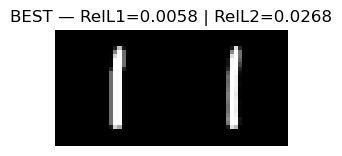

Saved best pair to: /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/output/vqvae_20250925_040159/vqvae_test_best_pair.png


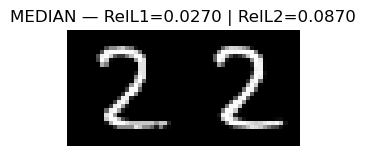

Saved median pair to: /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/output/vqvae_20250925_040159/vqvae_test_median_pair.png


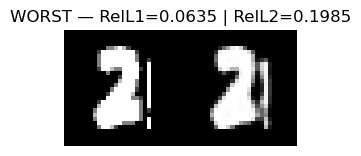

Saved worst pair to: /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/output/vqvae_20250925_040159/vqvae_test_worst_pair.png


In [45]:
# Worst / Median / Best reconstructions by Relative L2
images, recons, errs = [], [], []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        xhat, _ = vqvae(xb)
        _, r2 = per_sample_rel_errors(xhat, xb)
        images.append(xb.cpu()); recons.append(xhat.cpu()); errs.append(r2.cpu())

images = torch.cat(images)   # (N,1,28,28)
recons = torch.cat(recons)
errs   = torch.cat(errs)

worst_idx  = torch.argmax(errs).item()
best_idx   = torch.argmin(errs).item()
median_val = torch.median(errs).item()
median_idx = (errs - median_val).abs().argmin().item()
print("Indices → BEST:", best_idx, "| MEDIAN:", median_idx, "| WORST:", worst_idx)

def show_pair(orig, recon, title, save_path=None):
    o = inv_normalize(orig).clamp(0,1).squeeze(0)   # (H,W)
    r = inv_normalize(recon).clamp(0,1).squeeze(0)  # (H,W)
    both = torch.cat([o, r], dim=-1)
    plt.figure(figsize=(3,3))
    plt.axis('off'); plt.title(title)
    plt.imshow(both, cmap='gray')
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', dpi=160)
    plt.show()

with torch.no_grad():
    for label, idx in [("BEST", best_idx), ("MEDIAN", median_idx), ("WORST", worst_idx)]:
        x  = images[idx:idx+1]
        xr = recons[idx:idx+1]
        r1, r2 = per_sample_rel_errors(xr, x)
        fp = vq_exp_dir / f"vqvae_test_{label.lower()}_pair.png"
        show_pair(x[0], xr[0], f"{label} — RelL1={r1.item():.4f} | RelL2={r2.item():.4f}", fp)
        print(f"Saved {label.lower()} pair to:", fp.resolve())

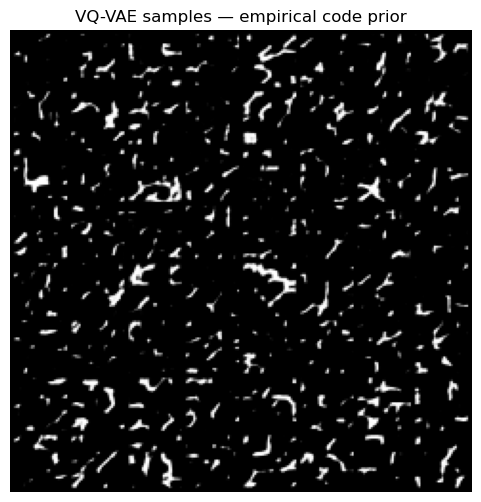

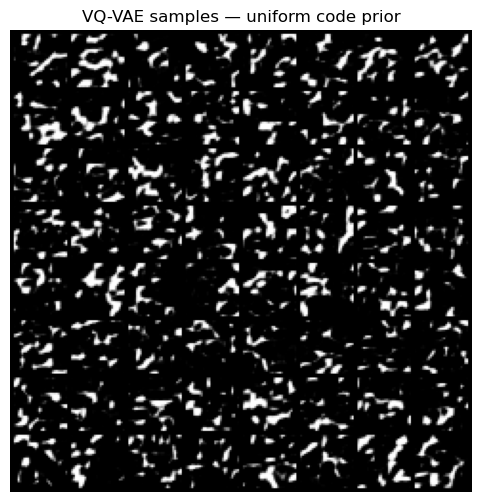

Saved samples to:
  /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/output/vqvae_20250925_040159/vqvae_samples_empirical.png 
  /Users/admin/Documents/workspace/code/github/ae-vae-vqvae/output/vqvae_20250925_040159/vqvae_samples_uniform.png


In [46]:
# Sampling from code priors (empirical & uniform)
from torchvision.utils import make_grid

@torch.no_grad()
def decode_from_indices(idx_map, codebook):
    """
    idx_map: (B, H, W) long tensor of code indices
    codebook: (K, D) tensor of embeddings
    returns z_q: (B, D, H, W)
    """
    B, H, W = idx_map.shape
    D = codebook.shape[1]
    flat = idx_map.view(B, -1)                       # (B, H*W)
    emb = codebook.index_select(0, flat.view(-1))    # (B*H*W, D)
    emb = emb.view(B, H, W, D).permute(0, 3, 1, 2).contiguous()
    return emb

# Prepare priors
H = W = 7
n = 64  # 8x8 grid of samples

# 1) Empirical prior (from train usage)
train_probs = train_prior.to(device)
emp_idx = torch.multinomial(train_probs, num_samples=n*H*W, replacement=True).view(n, H, W)

# 2) Uniform prior
uni_idx = torch.randint(low=0, high=K, size=(n, H, W), device=device)

with torch.no_grad():
    zq_emp = decode_from_indices(emp_idx, vqvae.quant.embedding)
    zq_uni = decode_from_indices(uni_idx, vqvae.quant.embedding)
    samp_emp = vqvae.decoder(zq_emp).cpu()
    samp_uni = vqvae.decoder(zq_uni).cpu()

    samp_emp_vis = inv_normalize(samp_emp).clamp(0,1)
    samp_uni_vis = inv_normalize(samp_uni).clamp(0,1)

grid_emp = make_grid(samp_emp_vis, nrow=8, padding=2)
grid_uni = make_grid(samp_uni_vis, nrow=8, padding=2)

plt.figure(figsize=(6,6)); plt.axis('off'); plt.title("VQ-VAE samples — empirical code prior")
plt.imshow(np.transpose(grid_emp.numpy(), (1,2,0))); plt.show()
plt.figure(figsize=(6,6)); plt.axis('off'); plt.title("VQ-VAE samples — uniform code prior")
plt.imshow(np.transpose(grid_uni.numpy(), (1,2,0))); plt.show()

fp_emp = vq_exp_dir / "vqvae_samples_empirical.png"
fp_uni = vq_exp_dir / "vqvae_samples_uniform.png"
plt.imsave(fp_emp, np.transpose(grid_emp.numpy(), (1,2,0)))
plt.imsave(fp_uni, np.transpose(grid_uni.numpy(), (1,2,0)))
print("Saved samples to:\n ", fp_emp.resolve(), "\n ", fp_uni.resolve())